In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import statistics
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures

In [2]:
movie = pd.read_csv('movie_metadata.csv')

### DATA EXPLORATION AND DATA CLEANING

In [3]:
movie.shape

(5043, 28)

In [4]:
movie.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [5]:
movie = movie.drop_duplicates()
movie.reset_index(inplace=True)

In [6]:
movie.shape

(4998, 29)

In [7]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      4998 non-null   int64  
 1   color                      4979 non-null   object 
 2   director_name              4895 non-null   object 
 3   num_critic_for_reviews     4949 non-null   float64
 4   duration                   4983 non-null   float64
 5   director_facebook_likes    4895 non-null   float64
 6   actor_3_facebook_likes     4975 non-null   float64
 7   actor_2_name               4985 non-null   object 
 8   actor_1_facebook_likes     4991 non-null   float64
 9   gross                      4124 non-null   float64
 10  genres                     4998 non-null   object 
 11  actor_1_name               4991 non-null   object 
 12  movie_title                4998 non-null   object 
 13  num_voted_users            4998 non-null   int64

#### MOVIE TITLE

In [8]:
movie['movie_title'].to_list()[:10]

['Avatar\xa0',
 "Pirates of the Caribbean: At World's End\xa0",
 'Spectre\xa0',
 'The Dark Knight Rises\xa0',
 'Star Wars: Episode VII - The Force Awakens\xa0            ',
 'John Carter\xa0',
 'Spider-Man 3\xa0',
 'Tangled\xa0',
 'Avengers: Age of Ultron\xa0',
 'Harry Potter and the Half-Blood Prince\xa0']

In [9]:
movie['movie_title'] = movie['movie_title'].apply(lambda x:x.strip())
movie['movie_title'] = movie['movie_title'].apply(lambda x:x.replace('\xa0',''))
movie['movie_title'].to_list()[:10]

['Avatar',
 "Pirates of the Caribbean: At World's End",
 'Spectre',
 'The Dark Knight Rises',
 'Star Wars: Episode VII - The Force Awakens',
 'John Carter',
 'Spider-Man 3',
 'Tangled',
 'Avengers: Age of Ultron',
 'Harry Potter and the Half-Blood Prince']

#### GENRES

In [10]:
genre_df = movie[['genres', 'imdb_score']]
genre_df.head()

,genres,imdb_score
0,Action|Adventure|Fantasy|Sci-Fi,7.9
1,Action|Adventure|Fantasy,7.1
2,Action|Adventure|Thriller,6.8
3,Action|Thriller,8.5
4,Documentary,7.1


In [11]:
genre = {}
for i,row in genre_df.iterrows():
    genre_list = row['genres'].split('|')
    for gen in genre_list:
        if gen in genre:
            genre[gen].append(row['imdb_score'])
        else:
            genre[gen] = [row['imdb_score']]
    
for key, val in genre.items():
    genre[key] = sum(val)/len(val)

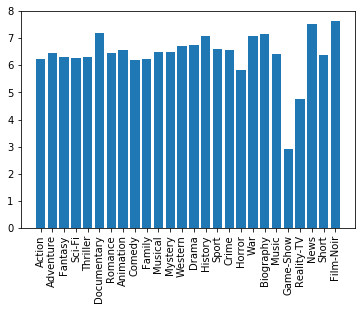

In [12]:
plt.bar(genre.keys(), genre.values())
plt.xticks(rotation=90)
plt.show()
# Game show and reality-tv had a general low score than others, and just can be used for categorical encoding. 

In [13]:
movie['genre-GameShow'] = None
movie['genre-RealityTV'] = None
for i, row in movie.iterrows():
    if 'Game-Show' in row['genres'].split('|'):
        movie.loc[i, 'genre-GameShow'] = 1
    else:
        movie.loc[i, 'genre-GameShow'] = 0
    if 'Reality-TV' in row['genres'].split('|'):
        movie.loc[i, 'genre-RealityTV'] = 1
    else:
        movie.loc[i, 'genre-RealityTV'] = 0

In [14]:
movie[movie['genre-RealityTV'] == 1][['genres','imdb_score']]

,genres,imdb_score
2131,Game-Show|Reality-TV|Romance,2.9
2356,Comedy|Drama|Reality-TV|Romance,6.6


In [15]:
movie[movie['genre-GameShow'] == 1][['genres','imdb_score']]

,genres,imdb_score
2131,Game-Show|Reality-TV|Romance,2.9


In [16]:
# Only single instance of game show and 2 instances of reality tv doesn't signify anything.
# In conclusion we can drop the genres column.
movie.drop(columns=['genres', 'genre-GameShow', 'genre-RealityTV'], inplace = True)
movie.columns

Index(['index', 'color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'movie_title',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

#### ASPECT RATIO

In [17]:
movie['aspect_ratio'].unique()

array([ 1.78,  2.35,   nan,  1.85,  2.  ,  2.2 ,  2.39,  2.24,  1.33,
        4.  ,  1.66,  1.5 , 16.  ,  1.77,  2.4 ,  1.37,  2.76,  1.18,
        1.44,  2.55,  1.2 ,  1.75,  1.89])

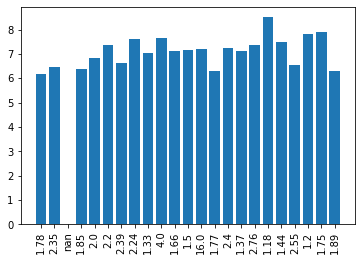

In [18]:
x = [str(i) for i in list(movie['aspect_ratio'].unique())]
y=[]
for asp in movie['aspect_ratio'].unique():
    y.append(movie[movie['aspect_ratio']==asp]['imdb_score'].mean())
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [19]:
#Aspect ratio dont have much impact on the imdb score
#we can remove them as well as the imdb link and index
movie.drop(columns=['aspect_ratio', 'movie_imdb_link', 'index'], inplace = True)
movie.shape

(4998, 25)

#### COLOR

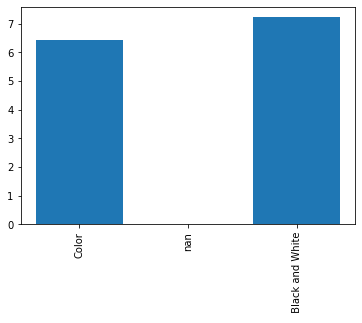

In [20]:
x = [str(i) for i in list(movie['color'].unique())]
y=[]
for col in movie['color'].unique():
    y.append(movie[movie['color']==col]['imdb_score'].mean())
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [21]:
movie['color'].value_counts()

Color               4772
 Black and White     207
Name: color, dtype: int64

In [22]:
# A huge proportion of movies are colored and with not much difference in avg. imdb score
# we can drop color column
movie.drop(columns=['color'], inplace = True)
movie.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'movie_title',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'num_user_for_reviews',
       'language', 'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
      dtype='object')

#### LANGUAGE


In [23]:
lang = movie['language'].value_counts()

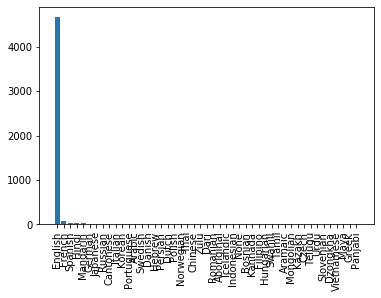

In [24]:
plt.bar(list(lang.index),lang.to_list())
plt.xticks(rotation=90)
plt.show()

In [25]:
# We can remove language as english is dominating with >95% data
movie.drop(columns=['language'], inplace = True)
movie.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'movie_title',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'num_user_for_reviews',
       'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
      dtype='object')

#### COUNTRY

In [26]:
country = movie['country'].value_counts()

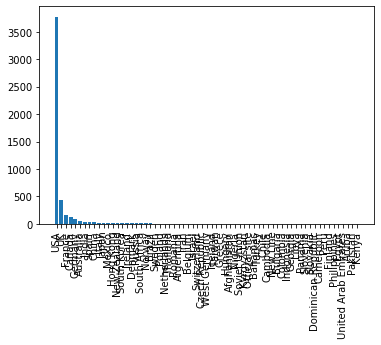

In [27]:
plt.bar(list(country.index),country.to_list())
plt.xticks(rotation=90)
plt.show()

In [28]:
country=country/country.sum()

In [29]:
country.head(10)

USA          0.755658
UK           0.088724
France       0.030843
Canada       0.024835
Germany      0.019227
Australia    0.011015
India        0.006810
Spain        0.006609
China        0.005608
Italy        0.004606
Name: country, dtype: float64

In [30]:
# USA and UK covers most of the proportion.
# we can substitute all others to 'Others' category.
movie.loc[~movie['country'].isin(['USA', 'UK']), 'country']='Others'
movie['country'].value_counts()

USA       3773
Others     782
UK         443
Name: country, dtype: int64

In [31]:
movie=pd.concat([movie, pd.get_dummies(movie['country'], prefix='country')],axis=1)
movie.drop(columns=['country'],inplace=True)
country_df = pd.DataFrame()
for col in movie.columns:
    if col.startswith('country_'):
        country_df = country_df.append({'country':col, 'correlation':movie.corr()['imdb_score'][col]}, ignore_index=True)
country_df = country_df.sort_values(['correlation'], ascending = (False),ignore_index=True)
country_df

,correlation,country
0,0.102973,country_UK
1,0.055071,country_Others
2,-0.114551,country_USA


#### DIRECTORS

In [32]:
len(movie['director_name'].unique())

2399

In [33]:
director_career = movie['director_name'].value_counts()
director_career[director_career>5]

Steven Spielberg    26
Woody Allen         22
Martin Scorsese     20
Clint Eastwood      20
Ridley Scott        17
                    ..
Mike Nichols         6
Roman Polanski       6
Mark Waters          6
Sidney Lumet         6
Stephen Hopkins      6
Name: director_name, Length: 145, dtype: int64

In [34]:
relevant_director = list(director_career[director_career>10].index)
relevant_director

['Steven Spielberg',
 'Woody Allen',
 'Martin Scorsese',
 'Clint Eastwood',
 'Ridley Scott',
 'Steven Soderbergh',
 'Spike Lee',
 'Tim Burton',
 'Renny Harlin',
 'Oliver Stone',
 'Joel Schumacher',
 'Robert Zemeckis',
 'Robert Rodriguez',
 'Sam Raimi',
 'Barry Levinson',
 'Ron Howard',
 'Michael Bay',
 'Kevin Smith',
 'Peter Jackson',
 'Brian De Palma',
 'Tony Scott',
 'Richard Donner',
 'John Carpenter',
 'Richard Linklater',
 'Shawn Levy',
 'Francis Ford Coppola',
 'Wes Craven',
 'Rob Reiner',
 'Chris Columbus']

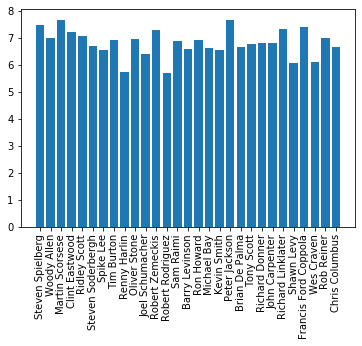

In [35]:
# Plotting mean imdb score
x = relevant_director
y=[]
for director in x:
    y.append(movie[movie['director_name']==director]['imdb_score'].mean())
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [36]:
consistent_director = []
for director in relevant_director:
    scores = movie[movie['director_name']==director]['imdb_score'].to_list()
    consistent = True
    thresh = 1
    for score in scores:
        if score < sum(scores)/len(scores)-thresh or score > sum(scores)/len(scores)+thresh:
            consistent = False
    if consistent:
        consistent_director.append(director)
consistent_director

['Sam Raimi', 'Michael Bay']

In [37]:
movie=pd.concat([movie, pd.get_dummies(movie['director_name'], prefix='director_name', dummy_na=True)],axis=1)
for director in tqdm(list(movie['director_name'].unique())):
    if director not in relevant_director:
        movie.drop(columns=['director_name_'+str(director)], inplace = True)
movie.head()

100%|██████████████████████████████████████████████████████████████████████████████| 2399/2399 [00:44<00:00, 54.33it/s]


,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,...,director_name_Ron Howard,director_name_Sam Raimi,director_name_Shawn Levy,director_name_Spike Lee,director_name_Steven Soderbergh,director_name_Steven Spielberg,director_name_Tim Burton,director_name_Tony Scott,director_name_Wes Craven,director_name_Woody Allen
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,CCH Pounder,Avatar,...,0,0,0,0,0,0,0,0,0,0
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Johnny Depp,Pirates of the Caribbean: At World's End,...,0,0,0,0,0,0,0,0,0,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Christoph Waltz,Spectre,...,0,0,0,0,0,0,0,0,0,0
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Tom Hardy,The Dark Knight Rises,...,0,0,0,0,0,0,0,0,0,0
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Doug Walker,Star Wars: Episode VII - The Force Awakens,...,0,0,0,0,0,0,0,0,0,0


In [38]:
director_df = pd.DataFrame()
for col in movie.columns:
    if col.startswith('director_name_'):
        director_df = director_df.append({'directors':col, 'correlation':movie.corr()['imdb_score'][col]}, ignore_index=True)

In [39]:
director_df = director_df.sort_values(['correlation'], ascending = (False),ignore_index=True)
director_df

,correlation,directors
0,0.068740,director_name_Martin Scorsese
1,0.066891,director_name_Steven Spielberg
2,0.053857,director_name_Peter Jackson
3,0.044209,director_name_Clint Eastwood
4,0.040828,director_name_Francis Ford Coppola
5,0.039374,director_name_Robert Zemeckis
6,0.037030,director_name_Richard Linklater
7,0.033603,director_name_Woody Allen
8,0.032720,director_name_Ridley Scott
9,0.024715,director_name_Tim Burton


In [40]:
# We can keep directors with correlation > 5% and remove the rest
keep_directors = ['director_name_Martin Scorsese', 'director_name_Steven Spielberg', 'director_name_Peter Jackson']
for col in movie.columns:
    if col.startswith('director_name'):
        if col not in keep_directors:
            movie.drop(columns=[col], inplace = True)
movie.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'num_user_for_reviews', 'content_rating', 'budget',
       'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes', 'country_Others', 'country_UK', 'country_USA',
       'director_name_Martin Scorsese', 'director_name_Peter Jackson',
       'director_name_Steven Spielberg'],
      dtype='object')

#### ACTORS


In [41]:
print(len(movie['actor_1_name'].unique()))
print(len(movie['actor_2_name'].unique()))
print(len(movie['actor_3_name'].unique()))

2098
3033
3522


In [42]:
actor1_career = movie['actor_1_name'].value_counts()
relevant_actor1 = list(actor1_career[actor1_career>10].index)
relevant_actor1[:10]

['Robert De Niro',
 'Johnny Depp',
 'Nicolas Cage',
 'J.K. Simmons',
 'Matt Damon',
 'Bruce Willis',
 'Denzel Washington',
 'Liam Neeson',
 'Harrison Ford',
 'Robin Williams']

In [43]:
movie=pd.concat([movie, pd.get_dummies(movie['actor_1_name'], prefix='actor_1_name', dummy_na=True)],axis=1)
for actor in tqdm(list(movie['actor_1_name'].unique())):
    if actor not in relevant_actor1:
        movie.drop(columns=['actor_1_name_'+str(actor)], inplace = True)
movie.head()

100%|██████████████████████████████████████████████████████████████████████████████| 2098/2098 [00:34<00:00, 60.90it/s]


,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,movie_title,num_voted_users,...,actor_1_name_Steve Buscemi,actor_1_name_Sylvester Stallone,actor_1_name_Tom Cruise,actor_1_name_Tom Hanks,actor_1_name_Tom Hardy,actor_1_name_Tom Wilkinson,actor_1_name_Viggo Mortensen,actor_1_name_Vin Diesel,actor_1_name_Will Ferrell,actor_1_name_Will Smith
0,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,CCH Pounder,Avatar,886204,...,0,0,0,0,0,0,0,0,0,0
1,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Johnny Depp,Pirates of the Caribbean: At World's End,471220,...,0,0,0,0,0,0,0,0,0,0
2,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Christoph Waltz,Spectre,275868,...,0,0,0,0,0,0,0,0,0,0
3,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Tom Hardy,The Dark Knight Rises,1144337,...,0,0,0,0,1,0,0,0,0,0
4,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Doug Walker,Star Wars: Episode VII - The Force Awakens,8,...,0,0,0,0,0,0,0,0,0,0


In [44]:
actor1_df = pd.DataFrame()
for col in movie.columns:
    if col.startswith('actor_1_name_'):
        actor1_df = actor1_df.append({'actors':col, 'correlation':movie.corr()['imdb_score'][col]}, ignore_index=True)

In [45]:
actor1_df = actor1_df.sort_values(['correlation'], ascending = (False),ignore_index=True)
actor1_df

,actors,correlation
0,actor_1_name_Leonardo DiCaprio,0.060922
1,actor_1_name_Tom Hanks,0.060808
2,actor_1_name_Harrison Ford,0.047092
3,actor_1_name_Christian Bale,0.045911
4,actor_1_name_Clint Eastwood,0.045198
...,...,...
69,actor_1_name_Bernie Mac,-0.015010
70,actor_1_name_Nicolas Cage,-0.016323
71,actor_1_name_Milla Jovovich,-0.019577
72,actor_1_name_Gary Oldman,-0.022160


In [46]:
# We can keep directors with correlation > 5% and remove the rest
keep_actors = ['actor_1_name_Leonardo DiCaprio', 'actor_1_name_Tom Hanks']
for col in movie.columns:
    if col.startswith('actor_1_name'):
        if col not in keep_actors:
            movie.drop(columns=[col], inplace = True)
movie.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'country_Others', 'country_UK', 'country_USA',
       'director_name_Martin Scorsese', 'director_name_Peter Jackson',
       'director_name_Steven Spielberg', 'actor_1_name_Leonardo DiCaprio',
       'actor_1_name_Tom Hanks'],
      dtype='object')

In [47]:
actor2_career = movie['actor_2_name'].value_counts()
relevant_actor2 = list(actor2_career[actor2_career>10].index)
movie=pd.concat([movie, pd.get_dummies(movie['actor_2_name'], prefix='actor_2_name', dummy_na=True)],axis=1)
for actor in tqdm(list(movie['actor_2_name'].unique())):
    if actor not in relevant_actor2:
        movie.drop(columns=['actor_2_name_'+str(actor)], inplace = True)
actor2_df = pd.DataFrame()
for col in movie.columns:
    if col.startswith('actor_2_name_'):
        actor2_df = actor2_df.append({'actors':col, 'correlation':movie.corr()['imdb_score'][col]}, ignore_index=True)
actor2_df = actor2_df.sort_values(['correlation'], ascending = (False),ignore_index=True)
actor2_df    

100%|██████████████████████████████████████████████████████████████████████████████| 3033/3033 [01:11<00:00, 42.38it/s]


,actors,correlation
0,actor_2_name_Morgan Freeman,0.030956
1,actor_2_name_Brad Pitt,0.028890
2,actor_2_name_Meryl Streep,0.023735
3,actor_2_name_Charlize Theron,0.011664
4,actor_2_name_James Franco,0.008161


In [48]:
# No actor2 has high correlation
for col in movie.columns:
    if col.startswith('actor_2_name'):
        movie.drop(columns=[col], inplace = True)
movie.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'country_Others', 'country_UK', 'country_USA',
       'director_name_Martin Scorsese', 'director_name_Peter Jackson',
       'director_name_Steven Spielberg', 'actor_1_name_Leonardo DiCaprio',
       'actor_1_name_Tom Hanks'],
      dtype='object')

In [49]:
actor3_career = movie['actor_3_name'].value_counts()
relevant_actor3 = list(actor3_career[actor3_career>10].index)
relevant_actor3

[]

In [50]:
# No actor3 is relevant enough
movie.drop(columns=['actor_3_name'], inplace = True)
movie.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'plot_keywords', 'num_user_for_reviews',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'movie_facebook_likes', 'country_Others', 'country_UK',
       'country_USA', 'director_name_Martin Scorsese',
       'director_name_Peter Jackson', 'director_name_Steven Spielberg',
       'actor_1_name_Leonardo DiCaprio', 'actor_1_name_Tom Hanks'],
      dtype='object')

#### PLOT KEYWORDS

In [51]:
movie['plot_keywords']

0                  avatar|future|marine|native|paraplegic
1       goddess|marriage ceremony|marriage proposal|pi...
2                     bomb|espionage|sequel|spy|terrorist
3       deception|imprisonment|lawlessness|police offi...
4                                                     NaN
                              ...                        
4993               fraud|postal worker|prison|theft|trial
4994         cult|fbi|hideout|prison escape|serial killer
4995                                                  NaN
4996                                                  NaN
4997    actress name in title|crush|date|four word tit...
Name: plot_keywords, Length: 4998, dtype: object

In [52]:
# Plot keywords are too diverse to affect the score, at the same time lets drop movie_title too, should have noticed earlier
movie.drop(columns=['plot_keywords', 'movie_title'], inplace = True)
movie.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'country_Others', 'country_UK', 'country_USA',
       'director_name_Martin Scorsese', 'director_name_Peter Jackson',
       'director_name_Steven Spielberg', 'actor_1_name_Leonardo DiCaprio',
       'actor_1_name_Tom Hanks'],
      dtype='object')

#### ACTOR DIRECTOR FACEBOOK LIKES

In [53]:
cor = movie.corr()
print('Director_likes', cor['imdb_score']['director_facebook_likes'])
print('Actor_1_likes', cor['imdb_score']['actor_1_facebook_likes'])
print('Actor_2_likes', cor['imdb_score']['actor_2_facebook_likes'])
print('Actor_3_likes', cor['imdb_score']['actor_3_facebook_likes'])

Director_likes 0.17156381256103043
Actor_1_likes 0.07595217660257446
Actor_2_likes 0.0824000362791679
Actor_3_likes 0.05168340847748046


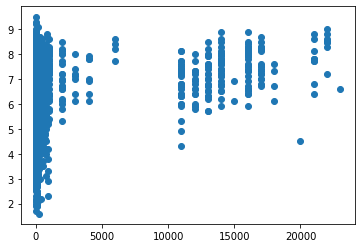

In [54]:
x=movie['director_facebook_likes'].to_list()
y=movie['imdb_score'].to_list()
plt.scatter(x,y)
plt.show()

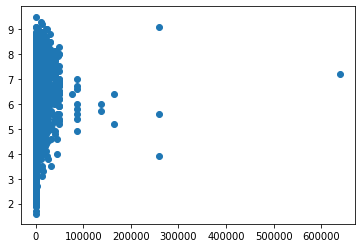

In [55]:
x=movie['actor_1_facebook_likes'].to_list()
y=movie['imdb_score'].to_list()
plt.scatter(x,y)
plt.show()

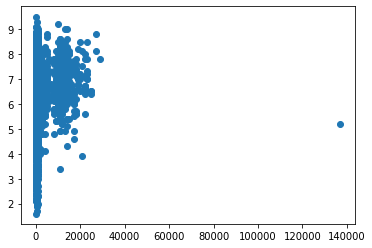

In [56]:
x=movie['actor_2_facebook_likes'].to_list()
y=movie['imdb_score'].to_list()
plt.scatter(x,y)
plt.show()

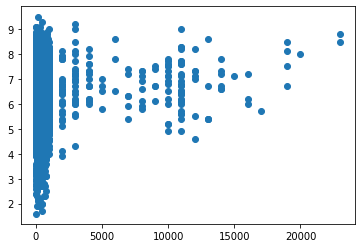

In [57]:
x=movie['actor_3_facebook_likes'].to_list()
y=movie['imdb_score'].to_list()
plt.scatter(x,y)
plt.show()

In [58]:
# These correlations are better than the one-hot encoding we did above
# i.e. the work we did earlier on actor director name is waste, lets remove them
remove_cols = keep_actors+keep_directors
movie.drop(columns=remove_cols, inplace = True)
movie.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'country_Others', 'country_UK', 'country_USA'],
      dtype='object')

#### DURATION

c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


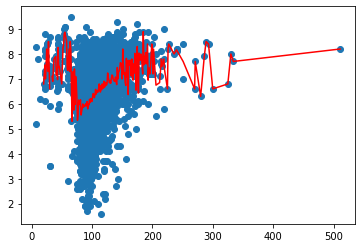

In [59]:
x=movie['duration'].to_list()
y=movie['imdb_score'].to_list()
r, s = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(x, y) if xVal==a])) for xVal in set(x)))
plt.scatter(x,y)
plt.plot(r,s,'r-')
plt.show()

In [60]:
movie.corr()['imdb_score']['duration']

0.2626182989045786

#### TITLE YEAR

In [61]:
movie['title_year'].head()

0    2009.0
1    2007.0
2    2015.0
3    2012.0
4       NaN
Name: title_year, dtype: float64

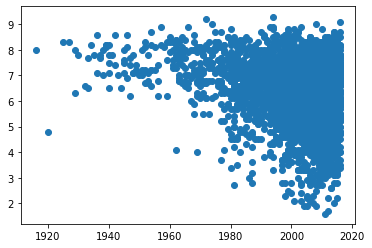

In [62]:
x=movie['title_year'].to_list()
y=movie['imdb_score'].to_list()
plt.scatter(x,y)
plt.show()

c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


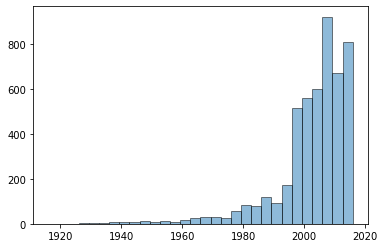

In [63]:
x=movie['title_year'].to_list()
plt.hist(x, bins=30, alpha=0.5, histtype='bar', ec='black')
plt.show()

In [64]:
#There are very few movies before 1980
len(movie[movie['title_year']<1980])

258

In [65]:
#We may remove these data as they may cause wrong representation
movie = movie[movie['title_year']>1980]
movie.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,country_Others,country_UK,country_USA
count,4569.000000,4597.000000,4609.000000,4593.000000,4602.000000,4.006000e+03,4.609000e+03,4609.000000,4596.000000,4594.000000,4.240000e+03,4609.000000,4599.000000,4609.000000,4609.000000,4609.000000,4609.000000,4609.000000
mean,145.369009,107.439199,655.700803,669.278032,6925.624076,4.816392e+07,8.490123e+04,10196.066175,1.367929,277.536569,4.186184e+07,2004.765459,1737.500326,6.363984,7821.235192,0.160338,0.084834,0.754828
std,123.245427,21.384398,2757.174372,1704.365381,15571.925379,6.794297e+07,1.385089e+05,18754.537536,2.017811,384.977025,2.132960e+08,7.852418,4169.503790,1.101195,19893.145891,0.366959,0.278665,0.430236
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1981.000000,0.000000,1.600000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,94.000000,7.000000,141.000000,637.000000,5.306974e+06,9.104000e+03,1484.000000,0.000000,66.000000,7.000000e+06,2000.000000,300.000000,5.700000,0.000000,0.000000,0.000000,1.000000
50%,116.000000,103.000000,47.000000,387.000000,1000.000000,2.531619e+07,3.583300e+04,3275.000000,1.000000,160.000000,2.000000e+07,2006.000000,619.000000,6.500000,162.000000,0.000000,0.000000,1.000000
75%,202.000000,117.000000,190.000000,648.000000,11000.000000,6.146750e+07,9.869300e+04,14504.000000,2.000000,334.000000,4.700000e+07,2011.000000,935.000000,7.100000,4000.000000,0.000000,0.000000,1.000000
max,813.000000,330.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.300000,349000.000000,1.000000,1.000000,1.000000


In [66]:
movie.corr()['imdb_score']['title_year']

-0.0947817538199504

#### ZERO VALUES

In [67]:
(len(movie) - movie.astype(bool).sum(axis=0)).sort_values()

num_critic_for_reviews          0
imdb_score                      0
title_year                      0
budget                          0
content_rating                  0
num_voted_users                 0
num_user_for_reviews            0
duration                        0
gross                           0
actor_1_facebook_likes         23
cast_total_facebook_likes      30
actor_2_facebook_likes         50
actor_3_facebook_likes         82
director_facebook_likes       836
country_USA                  1130
facenumber_in_poster         1964
movie_facebook_likes         1991
country_Others               3870
country_UK                   4218
dtype: int64

In [68]:
# Zero values other than categorical and facenumbers in poster should be treated as nan
# So that it can be replaced by median value later on
columns = ['actor_1_facebook_likes', 'cast_total_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes']
for cols in columns:
    movie.loc[movie[cols]==0, cols] = np.nan
(len(movie) - movie.astype(bool).sum(axis=0)).sort_values()

num_critic_for_reviews          0
movie_facebook_likes            0
imdb_score                      0
actor_2_facebook_likes          0
title_year                      0
budget                          0
content_rating                  0
num_user_for_reviews            0
num_voted_users                 0
gross                           0
actor_1_facebook_likes          0
actor_3_facebook_likes          0
director_facebook_likes         0
duration                        0
cast_total_facebook_likes       0
country_USA                  1130
facenumber_in_poster         1964
country_Others               3870
country_UK                   4218
dtype: int64

#### NULL VALUES

In [69]:
movie.isnull().sum().sort_values()

country_USA                     0
country_Others                  0
imdb_score                      0
title_year                      0
country_UK                      0
num_voted_users                 0
duration                       12
facenumber_in_poster           13
num_user_for_reviews           15
actor_1_facebook_likes         30
cast_total_facebook_likes      30
num_critic_for_reviews         40
actor_2_facebook_likes         60
actor_3_facebook_likes         98
content_rating                253
budget                        369
gross                         603
director_facebook_likes       836
movie_facebook_likes         1991
dtype: int64

In [70]:
# Budget and gross have a huge impact on movie
# We cant just assign it a median value, it would be better for our dataset if we dropout the null value rows.
movie.dropna(subset=['gross'],inplace=True)
movie.dropna(subset=['budget'],inplace=True)

In [71]:
columns = ['cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'movie_facebook_likes', 'actor_2_facebook_likes', 'duration', 'facenumber_in_poster', 'num_user_for_reviews', 'actor_3_facebook_likes', 'num_critic_for_reviews']
for cols in columns:
    imputer = SimpleImputer(strategy = 'median')
    imputer.fit(np.asarray(movie[cols]).reshape(-1, 1))
    print(cols, '-', imputer.statistics_)
    filled = imputer.transform(np.asarray(movie[cols]).reshape(-1, 1))
    movie[cols]=filled

cast_total_facebook_likes - [3969.]
director_facebook_likes - [92.]
actor_1_facebook_likes - [1000.]
movie_facebook_likes - [10000.]
actor_2_facebook_likes - [681.]
duration - [105.]
facenumber_in_poster - [1.]
num_user_for_reviews - [200.]
actor_3_facebook_likes - [436.]
num_critic_for_reviews - [135.]


In [72]:
movie.isnull().sum().sort_values()

num_critic_for_reviews        0
country_Others                0
movie_facebook_likes          0
imdb_score                    0
actor_2_facebook_likes        0
title_year                    0
budget                        0
country_UK                    0
num_user_for_reviews          0
cast_total_facebook_likes     0
num_voted_users               0
gross                         0
actor_1_facebook_likes        0
actor_3_facebook_likes        0
director_facebook_likes       0
duration                      0
facenumber_in_poster          0
country_USA                   0
content_rating               50
dtype: int64

#### CONTENT RATING

In [73]:
movie['content_rating'].unique()
#PG – Parental Guidance Suggested
#PG-13 – Parents Strongly Cautioned
#G - General Audiences
#R – Restricted
#NC-17 – Adults Only
#X - Persons under 16 not admitted.
#TV-14 - parents may find unsuitable for children under 14 years of age.
#TV-G - This program is suitable for all ages
#TV-PG - This program contains material that parents may find unsuitable for younger children.

array(['PG-13', 'PG', 'G', 'R', 'NC-17', nan, 'X', 'Not Rated', 'Unrated'],
      dtype=object)

In [74]:
movie.loc[movie['content_rating']=='TV-PG', 'content_rating'] = 'PG'
movie.loc[movie['content_rating']=='TV-G', 'content_rating'] = 'G'
movie.loc[movie['content_rating']=='TV-14', 'content_rating'] = 'PG-13'
movie.loc[movie['content_rating']=='X', 'content_rating'] = 'NC-17'
movie['content_rating'].unique()

array(['PG-13', 'PG', 'G', 'R', 'NC-17', nan, 'Not Rated', 'Unrated'],
      dtype=object)

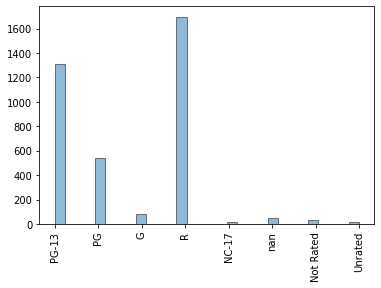

In [75]:
x=movie['content_rating'].to_list()
plt.hist(x, bins=30, alpha=0.5, histtype='bar', ec='black')
plt.xticks(rotation=90)
plt.show()

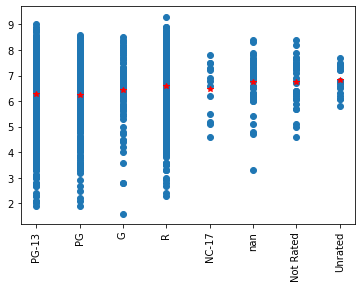

In [76]:
x=[str(x) for x in movie['content_rating']]
y=movie['imdb_score'].to_list()
plt.scatter(x,y)
r, s = zip(*sorted((xVal, np.mean([yVal for a, yVal in zip(x, y) if xVal==a])) for xVal in set(x)))
plt.plot(r,s,'r*')
plt.xticks(rotation=90)
plt.show()

In [77]:
movie=pd.concat([movie, pd.get_dummies(movie['content_rating'], prefix='content_rating', dummy_na=False)],axis=1)
content_rating_df = pd.DataFrame()
for col in movie.columns:
    if col.startswith('content_rating_'):
        content_rating_df = content_rating_df.append({'content':col, 'correlation':movie.corr()['imdb_score'][col]}, ignore_index=True)

In [78]:
content_rating_df

,content,correlation
0,content_rating_G,-0.002628
1,content_rating_NC-17,0.002287
2,content_rating_Not Rated,0.027108
3,content_rating_PG,-0.075362
4,content_rating_PG-13,-0.115094
5,content_rating_R,0.146804
6,content_rating_Unrated,0.026286


In [79]:
#Drop columns with less correlation
movie.drop(columns=['content_rating'], inplace = True)
movie.drop(columns=['content_rating_G'], inplace = True)
movie.drop(columns=['content_rating_NC-17'], inplace = True)
movie.drop(columns=['content_rating_Not Rated'], inplace = True)
movie.drop(columns=['content_rating_Unrated'], inplace = True)
movie.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'country_Others', 'country_UK', 'country_USA', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R'],
      dtype='object')

#### CORRELATION AND FEATURE REDUCTION

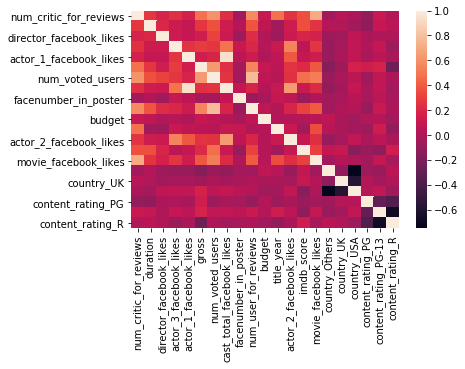

In [80]:
sns.heatmap(movie.corr())

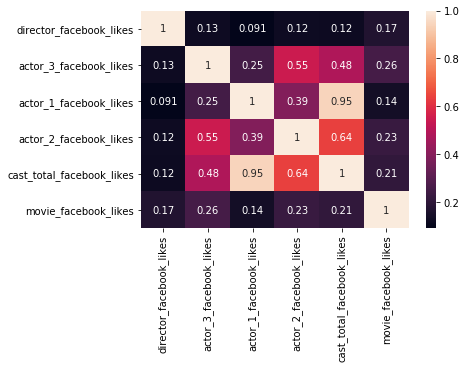

In [81]:
sns.heatmap(movie[['director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'cast_total_facebook_likes', 'movie_facebook_likes']].corr(), annot=True)

In [82]:
#We can see cast total facebook likes is highly correlated to actor_1 facebooks likes
#At the same time director and movie facebook likes are uncorrelated with others, so we can keep them.
movie['other_actor_facebook_likes'] =  movie['actor_3_facebook_likes']+movie['actor_2_facebook_likes']
movie.drop(columns=['actor_2_facebook_likes', 'actor_3_facebook_likes', 'cast_total_facebook_likes'], inplace = True)

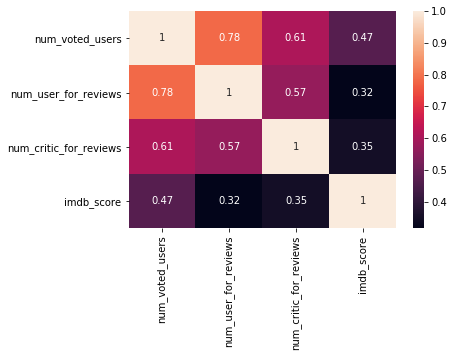

In [83]:
sns.heatmap(movie[['num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'imdb_score']].corr(), annot=True)

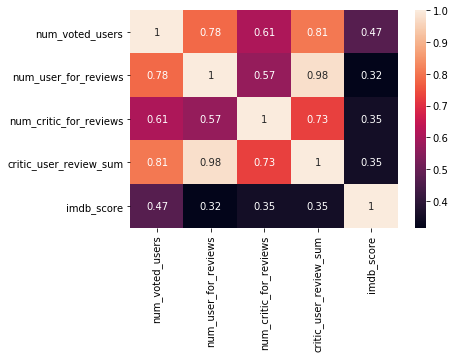

In [84]:
movie['critic_user_review_sum'] = movie['num_critic_for_reviews']+movie['num_user_for_reviews']
sns.heatmap(movie[['num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews','critic_user_review_sum', 'imdb_score']].corr(), annot=True)

In [85]:
movie.drop(columns=['num_user_for_reviews', 'num_critic_for_reviews'], inplace = True)
movie.columns

Index(['duration', 'director_facebook_likes', 'actor_1_facebook_likes',
       'gross', 'num_voted_users', 'facenumber_in_poster', 'budget',
       'title_year', 'imdb_score', 'movie_facebook_likes', 'country_Others',
       'country_UK', 'country_USA', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R',
       'other_actor_facebook_likes', 'critic_user_review_sum'],
      dtype='object')

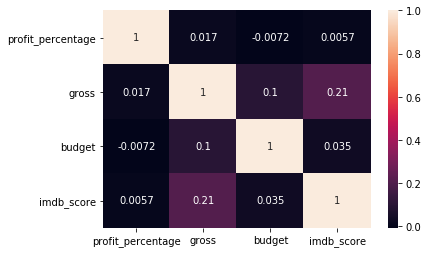

In [86]:
movie['profit_percentage'] = ((movie['gross']-movie['budget'])/movie['budget'])*100
sns.heatmap(movie[['profit_percentage', 'gross', 'budget', 'imdb_score']].corr(), annot=True)

In [87]:
# profit_percentage is of no use
movie.drop(columns=['profit_percentage'], inplace = True)
movie.columns

Index(['duration', 'director_facebook_likes', 'actor_1_facebook_likes',
       'gross', 'num_voted_users', 'facenumber_in_poster', 'budget',
       'title_year', 'imdb_score', 'movie_facebook_likes', 'country_Others',
       'country_UK', 'country_USA', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_R',
       'other_actor_facebook_likes', 'critic_user_review_sum'],
      dtype='object')

In [88]:
movie = movie.rename(columns={'director_facebook_likes': 'director_likes', 
                              'actor_1_facebook_likes' : 'main_actor_likes',
                              'num_voted_users': 'votes',
                              'title_year':'year',
                              'movie_facebook_likes':'movie_likes',
                              'content_rating_PG':'content_PG',
                              'content_rating_PG-13':'content_PG-13',
                              'content_rating_R':'content_R',
                              'other_actor_facebook_likes':'other_actors_likes',
                              'critic_user_review_sum':'reviews'})

In [89]:
movie.columns

Index(['duration', 'director_likes', 'main_actor_likes', 'gross', 'votes',
       'facenumber_in_poster', 'budget', 'year', 'imdb_score', 'movie_likes',
       'country_Others', 'country_UK', 'country_USA', 'content_PG',
       'content_PG-13', 'content_R', 'other_actors_likes', 'reviews'],
      dtype='object')

### TRAINING AND EVALUATION OF MODEL

In [90]:
data_split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
movie['score_category'] = np.ceil(movie['imdb_score'])
movie['score_category'].where(movie['score_category']<9, 9.0, inplace = True)
for train_index, test_index in data_split.split(movie, movie['score_category']):
    movie_train = movie.iloc[train_index]
    movie_test = movie.iloc[test_index]
print(len(movie_train), 'Train data, ', len(movie_test), 'Test data.')
movie_train.drop(columns=['score_category'], inplace = True)
movie_test.drop(columns=['score_category'], inplace = True)

2622 Train data,  1125 Test data.


c:\users\vivek\.conda\envs\machine_learning\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [91]:
movie_train.reset_index(inplace = True)
movie_train.drop(columns=['index'], inplace = True)
movie_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2622 entries, 0 to 2621
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              2622 non-null   float64
 1   director_likes        2622 non-null   float64
 2   main_actor_likes      2622 non-null   float64
 3   gross                 2622 non-null   float64
 4   votes                 2622 non-null   int64  
 5   facenumber_in_poster  2622 non-null   float64
 6   budget                2622 non-null   float64
 7   year                  2622 non-null   float64
 8   imdb_score            2622 non-null   float64
 9   movie_likes           2622 non-null   float64
 10  country_Others        2622 non-null   uint8  
 11  country_UK            2622 non-null   uint8  
 12  country_USA           2622 non-null   uint8  
 13  content_PG            2622 non-null   uint8  
 14  content_PG-13         2622 non-null   uint8  
 15  content_R            

In [92]:
movie_test.reset_index(inplace = True)
movie_test.drop(columns=['index'], inplace = True)
movie_test.info()
#Now we will not use our movie_test till our model is finalized.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              1125 non-null   float64
 1   director_likes        1125 non-null   float64
 2   main_actor_likes      1125 non-null   float64
 3   gross                 1125 non-null   float64
 4   votes                 1125 non-null   int64  
 5   facenumber_in_poster  1125 non-null   float64
 6   budget                1125 non-null   float64
 7   year                  1125 non-null   float64
 8   imdb_score            1125 non-null   float64
 9   movie_likes           1125 non-null   float64
 10  country_Others        1125 non-null   uint8  
 11  country_UK            1125 non-null   uint8  
 12  country_USA           1125 non-null   uint8  
 13  content_PG            1125 non-null   uint8  
 14  content_PG-13         1125 non-null   uint8  
 15  content_R            

In [93]:
y = np.asarray(movie_train['imdb_score'].copy()).reshape(-1,1)
X = np.asarray(movie_train.drop(columns=['imdb_score']).copy())

#### LINEAR REGRESSION - VALIDATION ON TRAINING DATA

In [94]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print('Bias = {} and coeficients are {}'.format(lin_reg.intercept_, lin_reg.coef_))

Bias = [21.53188837] and coeficients are [[ 1.06542110e-02  1.30754946e-05  3.01896871e-06 -1.30667978e-09
   3.44663897e-06 -2.60679277e-02 -8.41287899e-12 -7.93460806e-03
   7.03371817e-06  8.63894039e-02  1.55117751e-01 -2.41507154e-01
  -4.96451916e-01 -6.09138071e-01 -3.37222529e-01 -1.20163268e-06
  -2.62109801e-04]]


In [95]:
predicted = lin_reg.predict(X)

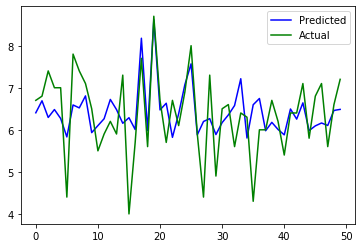

In [96]:
x_axis = list(range(50))
plt.plot(x_axis, predicted[50:100], 'b-', label='Predicted')
plt.plot(x_axis, y[50:100], 'g-', label='Actual')
plt.legend()
plt.show()

In [97]:
#Evaluation
mse = mean_squared_error(y, predicted)
rmse = np.sqrt(mse)
print('RMSE for Linear Regression on, evaluated on training set -', rmse)

RMSE for Linear Regression on, evaluated on training set - 0.8464329794227455


#### DECISION-TREE - VALIDATION ON TRAINING DATA

In [98]:
dec_reg = DecisionTreeRegressor()
dec_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [99]:
predicted = dec_reg.predict(X)

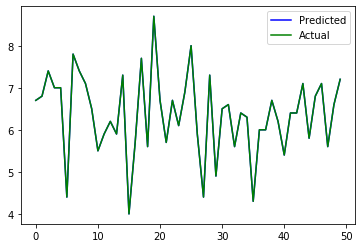

In [100]:
x_axis = list(range(50))
plt.plot(x_axis, predicted[50:100], 'b-', label='Predicted')
plt.plot(x_axis, y[50:100], 'g-', label='Actual')
plt.legend()
plt.show()

In [101]:
#Evaluation
mse = mean_squared_error(y, predicted)
rmse = np.sqrt(mse)
print('RMSE for Linear Regression on, evaluated on training set -', rmse)
#Performance is too good to be true
#Because when we use decision tree for regression, without tweaking the parameters, it always overfits the data.

RMSE for Linear Regression on, evaluated on training set - 1.6816971954885568e-16


#### LINEAR REGRESSION - CROSS VALIDATION

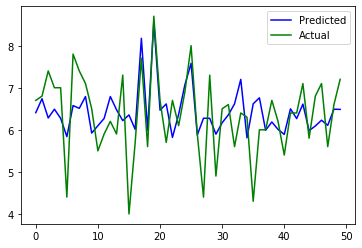

In [102]:
lin_reg_cross = LinearRegression()
predicted = cross_val_predict(lin_reg_cross, X, y, cv=10)
x_axis = list(range(50))
plt.plot(x_axis, predicted[50:100], 'b-', label='Predicted')
plt.plot(x_axis, y[50:100], 'g-', label='Actual')
plt.legend()
plt.show()

In [103]:
#Evaluation
mse = mean_squared_error(y, predicted)
rmse = np.sqrt(mse)
print('RMSE for Linear Regression on, cross-validated on training set -', rmse)

RMSE for Linear Regression on, cross-validated on training set - 0.8829977446949073


#### DECISION-TREE - CROSS VALIDATION

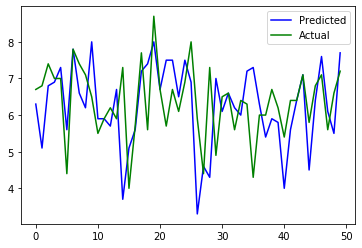

In [104]:
dec_reg_cross = DecisionTreeRegressor()
predicted = cross_val_predict(dec_reg_cross, X, y, cv=10)
x_axis = list(range(50))
plt.plot(x_axis, predicted[50:100], 'b-', label='Predicted')
plt.plot(x_axis, y[50:100], 'g-', label='Actual')
plt.legend()
plt.show()

In [105]:
mse = mean_squared_error(y, predicted)
rmse = np.sqrt(mse)
print('RMSE for decission tree Regression on, cross-validated on training set -', rmse)
# We can conclude that linear regression is better than decission tree regressor

RMSE for decission tree Regression on, cross-validated on training set - 1.05252049375715


### LINEAR REGRESSION - EVALUATION ON TESTING DATA

In [106]:
y = np.asarray(movie_test['imdb_score'].copy()).reshape(-1,1)
X = np.asarray(movie_test.drop(columns=['imdb_score']).copy())

In [107]:
predicted = lin_reg.predict(X)

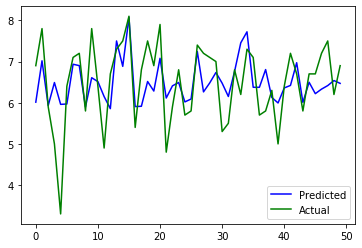

In [108]:
x_axis = list(range(50))
plt.plot(x_axis, predicted[50:100], 'b-', label='Predicted')
plt.plot(x_axis, y[50:100], 'g-', label='Actual')
plt.legend()
plt.show()

In [109]:
#Evaluation
mse = mean_squared_error(y, predicted)
rmse = np.sqrt(mse)
print('RMSE for Linear Regression on, evaluated on test dataset -', rmse)

RMSE for Linear Regression on, evaluated on test dataset - 0.8577023969065022


In [110]:
def mean_absolute_percentage_error(y, predicted):
    return (((abs(predicted.reshape(-1,1)-y)/y)*100).sum())/len(predicted)

In [111]:
print('mean absolute percentage error :', mean_absolute_percentage_error(y, predicted), '%')

mean absolute percentage error : 11.47370621535863 %


In [112]:
min_gap = np.inf
max_gap = 0
error = []
for i, j in enumerate(predicted.reshape(1,-1)[0]):
    error.append(abs(j-y.reshape(1,-1)[0][i]))
    if abs(j-y.reshape(1,-1)[0][i]) < min_gap:
        min_gap = abs(j-y.reshape(1,-1)[0][i])
    if abs(j-y.reshape(1,-1)[0][i]) > max_gap:
        max_gap = abs(j-y.reshape(1,-1)[0][i])
print('minimum error -', min_gap)
print('maximum error -', max_gap)

minimum error - 0.0002572465749999253
maximum error - 5.451133691698351


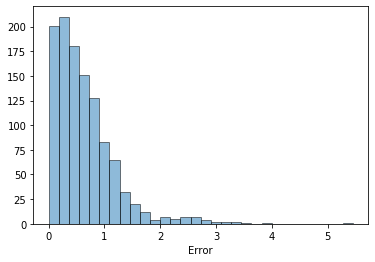

In [113]:
plt.hist(error, bins=30, alpha=0.5, histtype='bar', ec='black')
plt.xlabel('Error')
plt.show()

### PREPARING NEW UN-LABELED DATA FOR PREDICTION

In [114]:
def preprocessing(data):
    data.drop(columns=['color', 'director_name', 'actor_2_name', 'actor_1_name', 'movie_title', 'plot_keywords', 'movie_imdb_link', 'language', 'actor_3_name', 'genres', 'aspect_ratio'], inplace = True)
    data['reviews'] = data['num_critic_for_reviews']+data['num_user_for_reviews']
    data.drop(columns=['num_critic_for_reviews', 'num_user_for_reviews'], inplace = True)
    data['other_actors_likes'] = data['actor_3_facebook_likes'] + data['actor_2_facebook_likes']
    data['country_UK'] = 0
    data['country_USA'] = 0
    data['country_Others'] = 0
    data.loc[(data['country']=='USA'), 'country_USA'] = 1
    data.loc[(data['country']=='UK'), 'country_UK'] = 1
    data.loc[data['country'].isin(['UK', 'USA']) == False, 'country_Others'] = 1
    data.drop(columns=['country', 'actor_3_facebook_likes', 'actor_2_facebook_likes'], inplace = True)
    data['content_PG'] = 0
    data['content_PG-13'] = 0
    data['content_R'] = 0
    data.loc[data['content_rating']=='TV-PG', 'content_rating'] = 'PG'
    data.loc[data['content_rating']=='TV-14', 'content_rating'] = 'PG-13'
    data.loc[(data['content_rating']=='PG'), 'content_PG'] = 1
    data.loc[(data['content_rating']=='PG-13'), 'content_PG-13'] = 1
    data.loc[(data['content_rating']=='R'), 'content_R'] = 1
    data.drop(columns=['content_rating'], inplace = True)
    data.drop(columns=['cast_total_facebook_likes'],inplace=True)
    data = data.rename(columns={'director_facebook_likes': 'director_likes', 
                              'actor_1_facebook_likes' : 'main_actor_likes',
                              'num_voted_users': 'votes',
                              'title_year':'year',
                              'movie_facebook_likes':'movie_likes'})
    cols = ['duration', 'director_likes', 'main_actor_likes', 'gross', 'votes', 'facenumber_in_poster', 'budget', 'year', 'movie_likes', 'country_Others', 'country_UK', 'country_USA', 'content_PG', 'content_PG-13', 'content_R', 'other_actors_likes', 'reviews']
    data = data[cols]
    X = np.asarray(data)
    return X

In [115]:
# new_data - dataframe without imdb_score column
# prediction = lin_reg.predict(preprocessing(new_data))